In [1]:
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import warnings
import joblib

warnings.simplefilter(action='ignore', category=FutureWarning) # suppress some future warning
pd.options.mode.chained_assignment = None  # default='warn'

from os import path
from scipy.stats import poisson # TODO sostituisci con smf o sm?
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

# custom functions
from libs.utils import fix_continent_matches, show_cdf, show_cdf_splitted, format_dataframe, extract_continent_from_FIFA, check_records_validity, remove_outliers, get_match_result, format_columns

plt.style.use('ggplot')

# costanti
PATH_ORIGINAL_DST = 'dataset/original'
PATH_DST = 'dataset'

## Parte 1: Introduzione al dataset, formattazione e verifica

Si prende in analisi un dataset contenente 42483 risultati di partie di calcio internazionale maschile. L'obbiettivo finale del progetto è ottenere un predittore di partite di calcio internazionali, dato l'input.

In [2]:
df = pd.read_csv(path.join(PATH_ORIGINAL_DST ,'results.csv') )

print("Null values:", df.isnull().values.any(), "| shape:", df.shape)
print("***"*15)
print(df.info())

Null values: False | shape: (42483, 9)
*********************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42483 entries, 0 to 42482
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        42483 non-null  object
 1   home_team   42483 non-null  object
 2   away_team   42483 non-null  object
 3   home_score  42483 non-null  int64 
 4   away_score  42483 non-null  int64 
 5   tournament  42483 non-null  object
 6   city        42483 non-null  object
 7   country     42483 non-null  object
 8   neutral     42483 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 2.6+ MB
None


### Formattazione del dataset (Pre-processing)
Il dataset non contiene elementi nulli. Estraggo alcune informazioni aggiungendo alcune colonne alle presenti quali:
- L'anno in cui si è giocato il match dalla colonna `date`,
- Ottengo l'`outcome`, che è il risultato dell'incontro e lo popolo con: `Home` per vittoria della squadra di casa, `Draw` per il pareggio e `Away` per vittoria della squadra ospite
- Converto il valore `home_score` e `away_score` in `float` (servirà successivamente)
- Alcuni match risalgono a prima della prima guerra mondiale, di conseguenza alcuni nomi di nazioni e paesi sono cambiati nel tempo (alcune non esistono più o si sono divise in più nazioni)
- Formatto alcuni nomi di nazioni per adattarli al dataset FIFA utilizzato successivamente

In [3]:
df = format_dataframe(df)

In una partita di calcio, la convenzione vuole che la prima squadra è quella di casa.
Per prima cosa controllo dunque che la convenzione sia rispettata:

In [4]:
if len(df.query("away_team == country")) > 0:
    print("Trovati %d record incorenti con la convenzione" % len(df.query("away_team == country")))

Trovati 25 record incorenti con la convenzione


Visto l'esiguo numero di elementi li visualizzo

In [5]:
df.query("away_team == country")

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,outcome,year
788,1924-03-13,Catalonia,Spain,0.0,7.0,Friendly,Barcelona,Spain,False,Away,1924
1618,1933-10-04,Silesia,Poland,1.0,2.0,Friendly,Katowice,Poland,False,Away,1933
1650,1934-02-02,Catalonia,Spain,0.0,2.0,Friendly,Barcelona,Spain,False,Away,1934
2754,1947-10-19,Catalonia,Spain,3.0,1.0,Friendly,Barcelona,Spain,False,Home,1947
3487,1953-04-26,Silesia,Poland,2.0,3.0,Friendly,Chorzów,Poland,False,Away,1953
3526,1953-08-09,Catalonia,Spain,0.0,6.0,Friendly,Barcelona,Spain,False,Away,1953
3539,1953-09-13,Silesia,Poland,3.0,3.0,Friendly,Byton,Poland,False,Draw,1953
28848,2006-11-19,Crimea,Northern Cyprus,0.0,5.0,ELF Cup,Lefkoşa,Northern Cyprus,True,Away,2006
28898,2006-12-09,Silesia,Poland,1.0,1.0,Friendly,Chorzów,Poland,False,Draw,2006
31765,2009-10-28,South Africa,Zimbabwe,1.0,1.0,COSAFA Cup,Harare,Zimbabwe,True,Draw,2009


Vi sono in totale 25 incoerenze che non rispettano la convenzione di sopra.
- I record con `neutral = True` sono incoerenti devono essere cambiati
- I restanti `team` sono antecedenti alle nazioni attuali: ad esempio la <i>Silesia</i> è una regione storica dell'Europa centrale appartenente oggi per la maggiorparte
ai territori della Polonia, Germania e Repubblica Ceca. Questi dati saranno successivamente droppati successivamente.

In [6]:
for i in df.query("away_team == country and neutral == True").index:
    df.at[i, "neutral"] = False

Controllo adesso la presenza di ulteriori incoerenze nel caso in cui `home_team = contry` e `neutral = True`

In [7]:
df.query("home_team == country and neutral == True")

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,outcome,year
10966,1979-08-29,Fiji,Papua New Guinea,0.0,0.0,South Pacific Games,Suva,Fiji,True,Draw,1979
35360,2013-07-15,Bermuda,Falkland Islands,8.0,0.0,Island Games,Hamilton,Bermuda,True,Home,2013
40116,2018-09-09,St. Kitts and Nevis,Puerto Rico,1.0,0.0,CONCACAF Nations League qualification,Basseterre,St. Kitts and Nevis,True,Home,2018
40399,2018-11-18,St. Kitts and Nevis,Canada,0.0,1.0,CONCACAF Nations League qualification,Basseterre,St. Kitts and Nevis,True,Away,2018
40757,2019-06-07,China PR,Philippines,2.0,0.0,Friendly,Guangzhou,China PR,True,Home,2019
41044,2019-08-11,St. Vincent / Grenadines,Trinidad and Tobago,1.0,0.0,Friendly,Georgetown,St. Vincent / Grenadines,True,Home,2019
41046,2019-08-27,St. Kitts and Nevis,Antigua and Barbuda,4.0,3.0,Friendly,Basseterre,St. Kitts and Nevis,True,Home,2019
41110,2019-09-06,USA,Mexico,0.0,3.0,Friendly,East Rutherford,USA,True,Away,2019
41229,2019-09-18,Congo DR,Rwanda,2.0,3.0,Friendly,Kinshasa,Congo DR,True,Away,2019
42068,2021-03-29,Congo DR,Gambia,1.0,0.0,African Cup of Nations qualification,Kinshasa,Congo DR,True,Home,2021


Correggo:

In [ ]:
for i in df.query("home_team == country and neutral == True").index:
    df.at[i, "neutral"] = False

In [9]:
not_neutral_games = df.query("neutral == False")

invalid_ = not_neutral_games.query("away_team == country")

invalid_copy = invalid_.copy()

invalid_.loc[invalid_.index.values, 'home_team'] = invalid_copy.loc[invalid_.index.values, 'away_team']
invalid_.loc[invalid_.index.values, 'home_score'] = invalid_copy.loc[invalid_.index.values, 'away_score'] 
invalid_.loc[invalid_.index.values, 'away_team'] = invalid_copy.loc[invalid_.index.values, 'home_team'] 
invalid_.loc[invalid_.index.values, 'away_score'] = invalid_copy.loc[invalid_.index.values, 'home_score'] 
invalid_['outcome'] = invalid_['outcome'].replace({"Home": "Away", "Away":"Home"})

for i in invalid_.index.values:
    df.loc[i, 'home_team'] = invalid_.loc[i, 'home_team']
    df.loc[i, 'home_score'] = invalid_.loc[i, 'home_score']
    df.loc[i, 'away_team'] = invalid_.loc[i, 'away_team']
    df.loc[i, 'away_score'] = invalid_.loc[i, 'away_score']
    df.loc[i, 'outcome'] = invalid_.loc[i, 'outcome']

In [5]:
df.to_csv(path.join(PATH_DST, 'dataset_v1.csv'))

NameError: name 'df' is not defined

Data la presenza di partite di nazioni non più presenti e dato l'obbiettivo iniziale del dataset di predirre il risultato di un match dato lo storico
dei risultati delle rispettive squadre è necessario non considerare una parte dei record presenti. Per fare ciò, filtro le squadre utilizzando il dataset [FIFA-RANKING](http://en.fifaranking.net/data/)

In [4]:
df_fifa = pd.read_csv(path.join(PATH_ORIGINAL_DST, 'fifa_ranking-2021-05-27.csv'))

df_fifa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63054 entries, 0 to 63053
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               63054 non-null  int64 
 1   rank             63054 non-null  int64 
 2   country_full     63054 non-null  object
 3   country_abrv     63054 non-null  object
 4   total_points     63054 non-null  int64 
 5   previous_points  63054 non-null  int64 
 6   rank_change      63054 non-null  int64 
 7   confederation    63054 non-null  object
 8   rank_date        63054 non-null  object
dtypes: int64(5), object(4)
memory usage: 4.3+ MB


Il dataset presenta 8 colonne che contengono le informazioni sulle quadre internazionali che partecipano alle competizioni FIFA.
La funzione `check_records_validity` permette di filtrare tutti i match presenti nel dataset di riferimento e verificare l'appartenenza delle due squadre nel dataset FIFA.

In [8]:
df = pd.read_csv(path.join(PATH_DST, 'dataset_v1.csv'))

df = check_records_validity(df, df_fifa)

df_valid = df.query("is_valid == True").drop(columns=['is_valid']).reset_index(drop=True)
df_not_valid = df.query("is_valid == False").drop(columns=['is_valid']).reset_index(drop=True)

if len(df_valid) + len(df_not_valid) == len(df):
    print("valid: %s not valid: %s, totale di record esaminati %s" % ( len(df_valid),len(df_not_valid), len(df) ) )
else:
    print("Something wrong happened!")

Total country: 216
valid: 41685 not valid: 798, totale di record esaminati 42483


Dato che servirà successivamente, realizzo un dataframe, che salverò come csv con  l'elenco delle nazioni che hanno giocato almeno 1 match con la rispettiva confederazione

In [12]:
df_fifa = df_fifa.drop(columns=['id','rank', 'country_abrv', 'total_points', 'previous_points', 'rank_change', 'rank_date']).sort_values(by='country_full').drop_duplicates().reset_index(drop=True)

df_unvalid_country = pd.DataFrame()

# estraggo tutti i team presenti in dataset_reduced_fixed
df_ht = df_valid['home_team'].drop_duplicates().sort_values().reset_index().drop(labels=['index'], axis=1).rename(columns={'home_team': 'team'})
df_at = df_valid['away_team'].drop_duplicates().sort_values().reset_index().drop(labels=['index'], axis=1).rename(columns={'away_team': 'team'})

df_valid_country = pd.concat([df_ht,df_at]).drop_duplicates().sort_values(by='team').reset_index().drop(labels=['index'], axis=1)

df_valid_country['confederation'] = ""

for i, row in df_valid_country.iterrows():
    if(len(df_fifa.query("country_full == @row.team")) > 0):
        df_valid_country.at[i, 'confederation'] = df_fifa.query("country_full == @row.team").confederation.values[0]

df_valid_country.replace("", np.nan, inplace=True)

df_unvalid_country = df_valid_country[df_valid_country['confederation'].isna()]
df_unvalid_country.reset_index(drop=True, inplace=True)
df_unvalid_country.drop(labels=['confederation'], axis=1, inplace=True)

df_valid_country.dropna(subset = ['confederation'], inplace=True)
df_valid_country.reset_index(drop=True, inplace=True)

print("... Fixed. Number of teams: %d" % len(df_valid_country))

df_valid_country.to_csv(path.join(PATH_DST, 'valid_country.csv'))
df_unvalid_country.to_csv(path.join(PATH_DST, 'not_valid_country.csv'))

Not same length! Some mismatch on played matches
... Fixed. Number of teams: 209


Procedo con l'eliminazione di tutti i match in cui una delle due squadre è presente in `df_unvalid_countries`

In [13]:
for index, row in df_unvalid_country.iterrows():
    if(len(df.query("home_team == @row.team or away_team == @row.team")) > 0):
        df.drop(df.query("home_team == @row.team or away_team == @row.team").index.values, inplace=True)

print("Now dataset is formed by: %d records"% len(df))

Now dataset is formed by: 39217 records


Per evitare la presenza di ulteriori record incoerenti, controllo che tutte le squadre presenti nel dataset abbiano giocato almeno una partita in casa e fuori casa

In [14]:
if len(df['home_team'].drop_duplicates().sort_values().values) > len(df['away_team'].drop_duplicates().sort_values().values):
    print("Mismatch home_team > away_team: %s" % list(set(df['home_team'].drop_duplicates().sort_values().values).difference(df['away_team'].drop_duplicates().sort_values().values)))
elif len(df['home_team'].drop_duplicates().sort_values().values) < len(df['away_team'].drop_duplicates().sort_values().values):
    print("Mismatch home_team < away_team: %s" % list(set(df['away_team'].drop_duplicates().sort_values().values).difference(df['home_team'].drop_duplicates().sort_values().values)))
else:
    print("Home teams and away teams are the same")

Home teams and away teams are the same


In [15]:
df = df.reset_index(drop=True)
df.to_csv(path.join(PATH_DST, "v2/dataset.csv"))

## Parte 2: Statistica descrittiva - Distribuzione dei dati

In [3]:
df = pd.read_csv(path.join(PATH_DST, 'v2/dataset.csv')).drop(columns=['Unnamed: 0'])

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,outcome,year,is_valid
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,Draw,1872,True
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,Home,1873,True
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,Home,1874,True
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,Draw,1875,True
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,Home,1876,True


### Competizioni presenti nel dataset
Tramite un grafico a barre visualizzo il numero di competizioni giocate e la relativa frequenza

Number of tournaments: 114


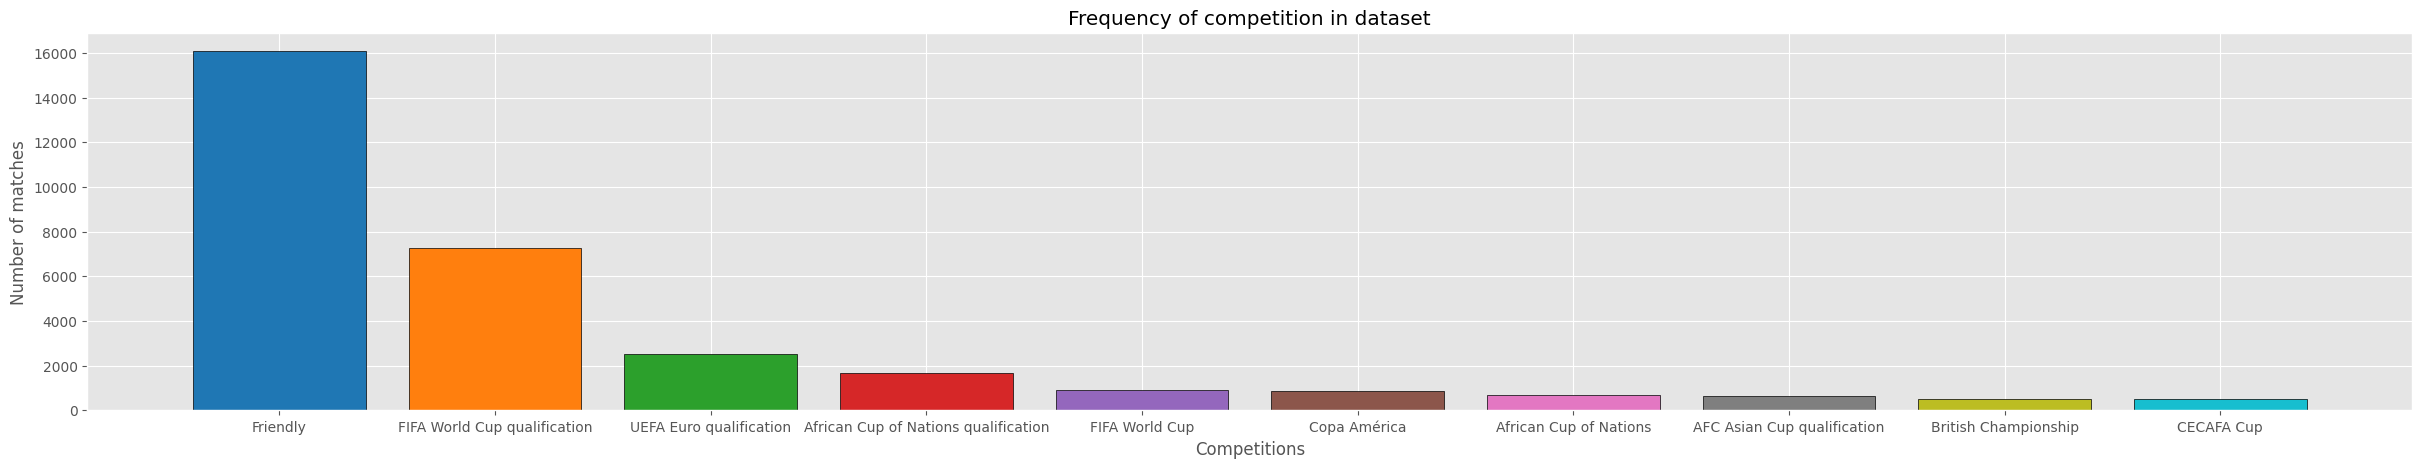

In [24]:
tournaments = df['tournament'].value_counts()

print("Numero di competizioni: %d" % ( len(tournaments) ))

plt.rcParams.update({'figure.figsize':(30,5), 'figure.dpi':100})
plt.title('Frequency of competition in dataset')
plt.ylabel('Number of matches')
plt.xlabel('Competitions')
plt.bar(tournaments.index[:10], tournaments.values[:10], color=[i for i in mcolors.TABLEAU_COLORS], edgecolor='black')
plt.show()

La maggiorparte delle partite disputate sono amichevoli seguiti dalle fasi di qualificazione dei 3 principali tornei mondiali FIFA

### Numero di partite disputate per anno

Visualizzo il numero di partite giocate per anno

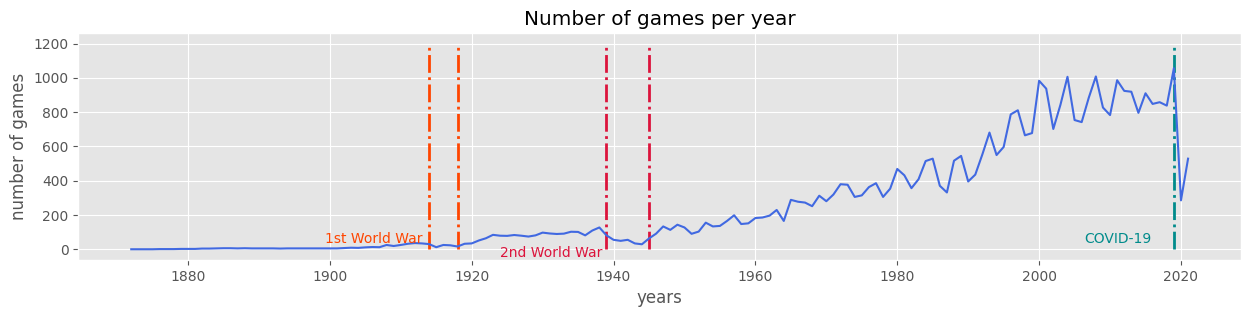

In [31]:
mpy = df['year'].value_counts().sort_index() # matches per year

plt.rcParams.update({'figure.figsize':(15,3), 'figure.dpi':100})
plt.title(label='Number of games per year')
plt.ylabel(ylabel='number of games')
plt.xlabel(xlabel='years')

l1 = [(1914,0), (1914,1200)]
l2 = [(1918,0), (1918,1200)]
l3 = [(1939,0), (1939,1200)]
l4 = [(1945,0), (1945,1200)]
l5 = [(2019,0), (2019, 1200)]

lc = LineCollection([l1, l2, l3, l4, l5], color=["orangered","orangered", "crimson","crimson", "darkcyan"], lw=2, linestyles='-.')

plt.annotate('1st World War', xy=(1914, 200), xycoords='data', ha='center', xytext=(-40, -20), textcoords='offset points', color='orangered')
plt.annotate('2nd World War', xy=(1939, 200), xycoords='data', ha='center', xytext=(-40, -30), textcoords='offset points', color='crimson')
plt.annotate('COVID-19', xy=(2019, 200), xycoords='data', ha='center', xytext=(-40, -20), textcoords='offset points', color='darkcyan')

plt.gca().add_collection(lc)

plt.plot(mpy, color='royalblue')
plt.grid(True)
plt.show()

Il numero di match si è abbassato durante le Guerre Mondiali ed è drasticamente calato durante la pandemia di Covid-19 ad inizio 2020.

### Numero di partite ospitate da ogni continente per anno

Per visualizzare l'adozione del calcio nel mondo visualizzo tramite ad un barplot il numero di partite ospitate da ogni continente per anno. Utilizzo nuovamente il dataset FIFA a disposizione
per estrarre il contienente in cui si è disputato il match.

In [32]:
df_fifa = pd.read_csv(path.join(PATH_ORIGINAL_DST,'fifa_ranking-2021-05-27.csv'))
df = extract_continent_from_FIFA(df, df_fifa)
df.to_csv(path.join(PATH_DST, "v2/dataset_continent.csv"))

# dataframe continent reduced, salvandolo a csv risolvo il problema del groupby che non assegna a tutte le colonne i continenti
df_cr = df.groupby(['continent','year']).size().to_csv('output.csv')
df_cr = pd.read_csv('output.csv')

# ordino per anno
df_cr.sort_values(by='year', axis=0, inplace=True)
df_cr = df_cr.reset_index().drop(columns=['index']).rename(columns={'0': 'matches'})

if df.__len__() == df_cr['matches'].sum():
    print("Groupby eseguito correttamente")

years = df_cr['year'].drop_duplicates().to_numpy()

africa = df_cr[df_cr['continent'] == 'Africa' ].reset_index().drop(columns=['continent', 'index'])
america = df_cr[df_cr['continent'] == 'America'].reset_index().drop(columns=['continent', 'index'])
asia = df_cr[df_cr['continent'] == 'Asia'].reset_index().drop(columns=['continent', 'index'])
europe = df_cr[df_cr['continent'] == 'Europe'].reset_index().drop(columns=['continent', 'index'])
oceania = df_cr[df_cr['continent'] == 'Oceania'].reset_index().drop(columns=['continent', 'index'])

All rows are correctly updated


Data l'adozione non uniforme dello sport per i vari continenti, uniformizzo la lunghezza dei DataFrame con la funzione `fix_continent_matches`

In [ ]:
print("First appearance in national match:\nAfrica: %d\nAmerica: %d\nAsia: %d\nEurope: %d\nOceania: %d" % (africa['year'].min(), america['year'].min(), asia['year'].min(), europe['year'].min(), oceania['year'].min() ))
africa  =   fix_continent_matches(years, africa)
america =   fix_continent_matches(years, america)
asia    =   fix_continent_matches(years, asia)
europe  =   fix_continent_matches(years, europe)
oceania =   fix_continent_matches(years, oceania)

if len(africa) == len(europe) == len(america) == len(oceania) == len(asia):
    print("All df have the same number of rows")

plt.rcParams.update({'figure.figsize':(15,3), 'figure.dpi':100})
plt.title('Number of games played by each continent')
plt.ylabel('Number of matches')
plt.xlabel('Years')
plt.bar(years, europe.matches.values, color='steelblue')
plt.bar(years, america.matches.values, bottom=europe.matches.values , color='crimson')
plt.bar(years, asia.matches.values, bottom = europe.matches.values+america.matches.values, color='darkorange')
plt.bar(years, oceania.matches.values, bottom = europe.matches.values+america.matches.values+asia.matches.values , color='salmon')
plt.bar(years, africa.matches.values, bottom=europe.matches.values + america.matches.values + asia.matches.values + oceania.matches.values, color='gold')
plt.legend(['Europe', 'America', 'Asia', 'Oceania', 'Africa'])

plt.show()

Dal grafico si evince che Europa ed America sono i continenti dove si sono disputato più partite.
Il numero di partite disputate in oceania è irrilevante rispetto al numero degli altri continenti nonostante l'Africa sia stata l'ultima ad aver ospitato una partita ufficiale.

### Estrazione statistiche squadre presenti nel dataset
Dopo aver 

In [42]:
df = pd.read_csv(path.join(PATH_DST, 'v2/dataset_continent.csv')).drop(columns=['Unnamed: 0'])

valid_country = pd.read_csv(path.join(PATH_DST, 'valid_country.csv')).drop(columns=['Unnamed: 0']).team.values
df_country = df.country.drop_duplicates().values

not_valid_country = []

for i in df_country:
    if i not in valid_country:
        not_valid_country.append(i)

print("Lunghezza del dataframe prima della validazione: %s" % (len(df)) )

for i, row in df.iterrows():
    if(row.country in not_valid_country):
        df.drop(i, inplace=True)

print("Lunghezza del dataframe dopo la validazione: %s" % (len(df)) )

df = df.reset_index(drop=True).to_csv(path.join(PATH_DST, 'v3/dataset.csv'))

Lunghezza del dataframe prima della validazione: 39217
Lunghezza del dataframe dopo la validazione: 38379


creo un dataframe con le statistiche di ogni squadra per vedere se ci sono delle correlazioni sul giocare in casa o no nello specifico
e nei goal subiti/segnati

In [ ]:
df = pd.read_csv(path.join(PATH_DST, 'v3/dataset.csv')).drop(columns=['Unnamed: 0'])
teams = pd.read_csv(path.join(PATH_DST, 'valid_country.csv')).drop(columns=['Unnamed: 0'])

teams['games'] = 0
teams['home_games'] = 0
teams['away_games'] = 0
teams['neutral_games'] = 0

teams['wins'] = 0
teams['home_wins'] = 0
teams['away_wins'] = 0
teams['neutral_wins'] = 0

teams['defeats'] = 0
teams['home_defeats'] = 0
teams['away_defeats'] = 0
teams['neutral_defeats'] = 0

teams['draws'] = 0
teams['home_draws'] = 0
teams['away_draws'] = 0
teams['neutral_draws'] = 0

teams['goals_scored'] = 0
teams['home_goals_scored'] = 0
teams['away_goals_scored'] = 0
teams['neutral_goals_scored'] = 0

teams['goals_conceded'] = 0
teams['home_goals_conceded'] = 0
teams['away_goals_conceded'] = 0
teams['neutral_goals_conceded'] = 0

counter = 0
for team in teams.team.values:
    print('*** Processing %d/%d ***' % (counter, len(teams.team.values)), end='\r')

    team_df = df.query("home_team == @team or away_team == @team")

    home_games_df = team_df.query("neutral == False and country == @team ")
    away_games_df = team_df.query("neutral == False and country != @team ")
    neutral_games_df = team_df.query("neutral == True ")

    teams.at[teams.team == team, 'games'] = len(team_df)
    teams.at[teams.team == team, 'home_games'] = len(home_games_df)
    teams.at[teams.team == team, 'away_games'] = len(away_games_df)
    teams.at[teams.team == team, 'neutral_games'] = len(neutral_games_df)

    query1 = "home_team == @team and outcome == 'Home' or away_team == @team and outcome == 'Away' "
    teams.at[teams.team == team, 'wins'] = len( team_df.query(query1) )
    teams.at[teams.team == team, 'home_wins'] = len(home_games_df.query(query1))
    teams.at[teams.team == team, 'away_wins'] = len(away_games_df.query(query1))
    teams.at[teams.team == team, 'neutral_wins'] = len(neutral_games_df.query(query1))

    query2 = "home_team == @team and outcome == 'Away' or away_team == @team and outcome == 'Home' "
    teams.at[teams.team == team, 'defeats'] = len( team_df.query(query2) )
    teams.at[teams.team == team, 'home_defeats'] = len(home_games_df.query(query2))
    teams.at[teams.team == team, 'away_defeats'] = len(away_games_df.query(query2))
    teams.at[teams.team == team, 'neutral_defeats'] = len(neutral_games_df.query(query2))

    query3 = "outcome == 'Draw' "
    teams.at[teams.team == team, 'draws'] = len(team_df.query(query3))
    teams.at[teams.team == team, 'home_draws'] = len(home_games_df.query(query3))
    teams.at[teams.team == team, 'away_draws'] = len(away_games_df.query(query3))
    teams.at[teams.team == team, 'neutral_draws'] = len(neutral_games_df.query(query3))

    teams.at[teams.team == team, 'goals_scored'] = team_df.query("home_team == @team")['home_score'].sum() + team_df.query("away_team == @team")['away_score'].sum()
    teams.at[teams.team == team, 'home_goals_scored'] = home_games_df.query("home_team == @team")['home_score'].sum() + home_games_df.query("away_team == @team")['away_score'].sum()
    teams.at[teams.team == team, 'away_goals_scored'] = away_games_df.query("home_team == @team")['home_score'].sum() + away_games_df.query("away_team == @team")['away_score'].sum()
    teams.at[teams.team == team, 'neutral_goals_scored'] = neutral_games_df.query("home_team == @team")['home_score'].sum() + neutral_games_df.query("away_team == @team")['away_score'].sum()

    teams.at[teams.team == team, 'goals_conceded'] = team_df.query("home_team == @team")['away_score'].sum() + team_df.query("away_team == @team")['home_score'].sum()
    teams.at[teams.team == team, 'home_goals_conceded'] = home_games_df.query("home_team == @team")['away_score'].sum() + home_games_df.query("away_team == @team")['home_score'].sum()
    teams.at[teams.team == team, 'away_goals_conceded'] = away_games_df.query("home_team == @team")['away_score'].sum() + away_games_df.query("away_team == @team")['home_score'].sum()
    teams.at[teams.team == team, 'neutral_goals_conceded'] = neutral_games_df.query("home_team == @team")['away_score'].sum() + neutral_games_df.query("away_team == @team")['home_score'].sum()

    counter = counter + 1

teams.to_csv(path.join(PATH_DST, 'teams_statistics.csv'))

In [62]:
# Calcolo la percentuale di ogni valore

teams_ = pd.read_csv(path.join(PATH_DST, 'teams_statistics.csv')).drop(columns=['Unnamed: 0'])

teams = teams_.copy()

for i in teams.columns.values[3:]: 
    teams[i] = teams[i].astype(float)

for i, row in teams.iterrows():
    games = row['games']
    for j in teams.columns.values[3:]:
        # per calcolare la percentuale moltiplico * 100 il rapporto tra a e b
        teams.at[i, j] = row[j] / games * 100

teams.to_csv(path.join(PATH_DST, 'teams_statistics_perc.csv'))

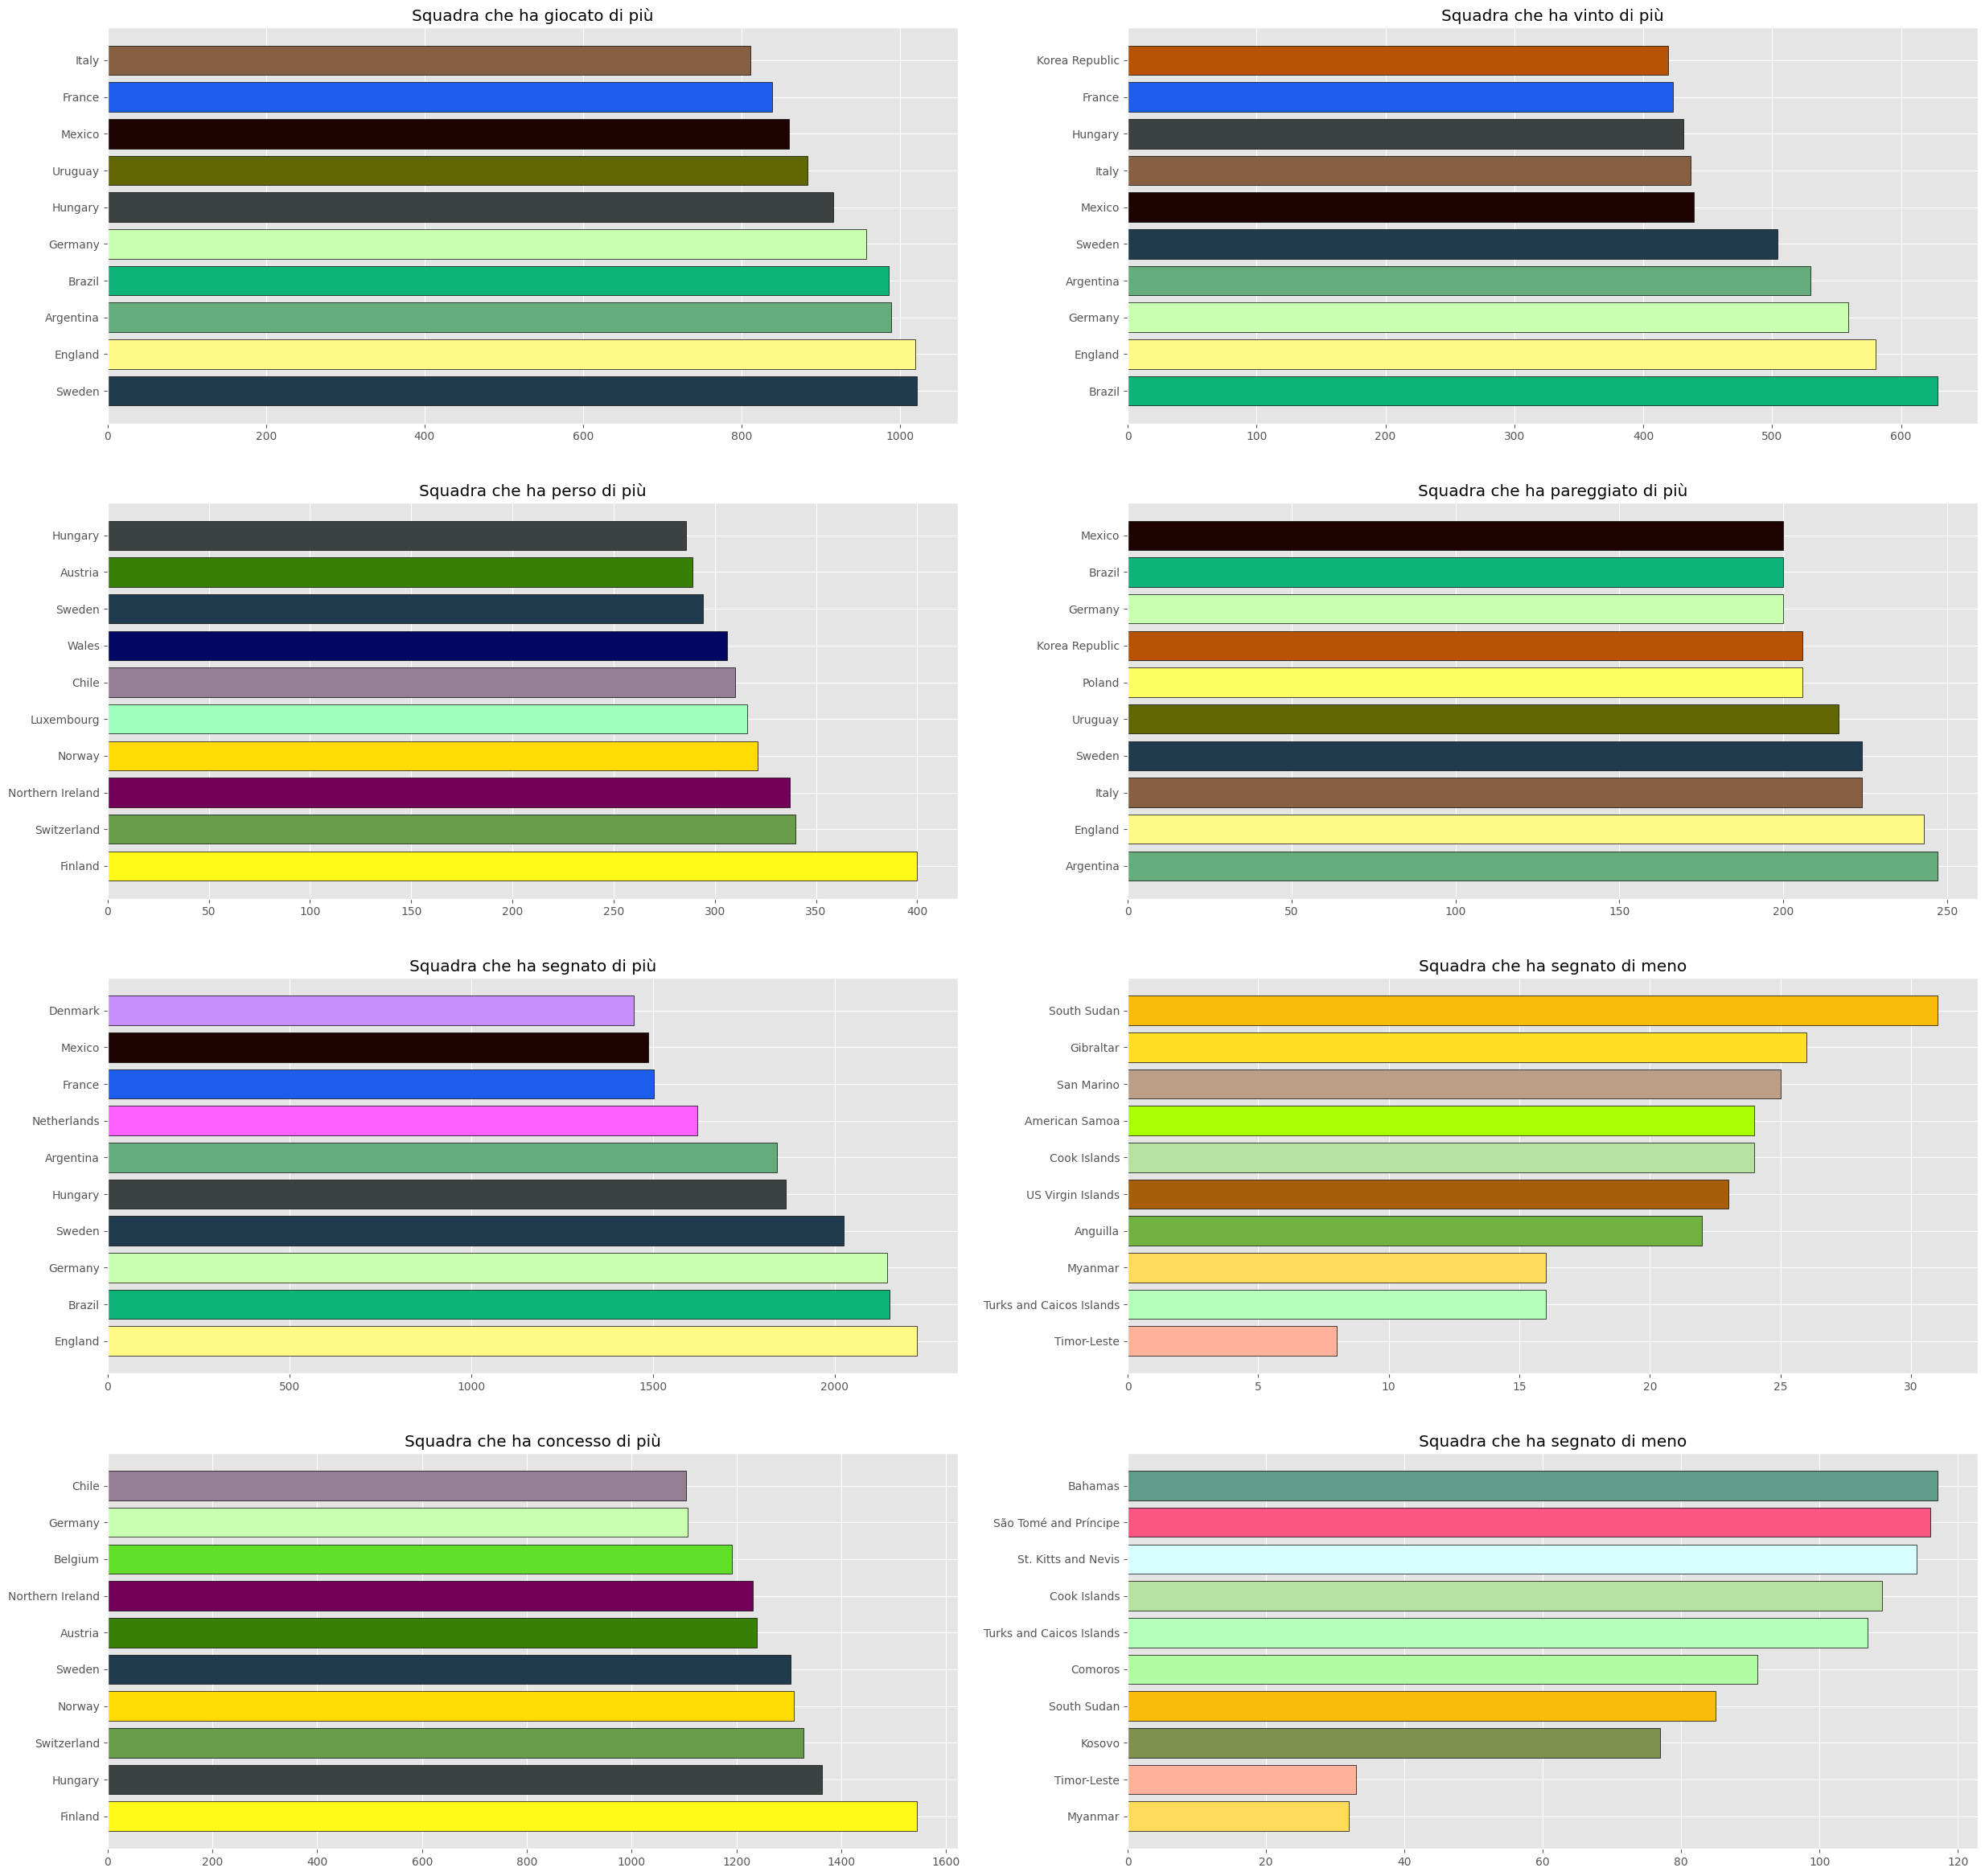

In [65]:
plt.rcParams.update({'figure.figsize':(30,30), 'figure.dpi':100})
fig, axs = plt.subplots(4, 2)

df = pd.read_csv(path.join(PATH_DST, 'teams_statistics.csv')).drop(columns=['Unnamed: 0'])
colors = list(mcolors.XKCD_COLORS)
df['color'] = colors[:len(df)]

df_axs = df.sort_values(by=['games'], ascending=False)
axs[0, 0].set_title("Squadra che ha giocato di più")
axs[0, 0].barh(df_axs.team.values[:10], df_axs.games.values[:10], color=df_axs.color.values[:10], edgecolor='black')

df_axs = df.sort_values(by=['wins'], ascending=False)
axs[0, 1].set_title("Squadra che ha vinto di più")
axs[0, 1].barh(df_axs.team.values[:10], df_axs.wins.values[:10], color=df_axs.color.values[:10], edgecolor='black')

df_axs = df.sort_values(by=['defeats'], ascending=False)
axs[1, 0].set_title("Squadra che ha perso di più")
axs[1, 0].barh(df_axs.team.values[:10], df_axs.defeats.values[:10], color=df_axs.color.values[:10], edgecolor='black')

df_axs = df.sort_values(by=['draws'], ascending=False)
axs[1, 1].set_title("Squadra che ha pareggiato di più")
axs[1, 1].barh(df_axs.team.values[:10], df_axs.draws.values[:10], color=df_axs.color.values[:10], edgecolor='black')

df_axs = df.sort_values(by=['goals_scored'], ascending=False)
axs[2, 0].set_title("Squadra che ha segnato di più")
axs[2, 0].barh(df_axs.team.values[:10], df_axs.goals_scored.values[:10], color=df_axs.color.values[:10], edgecolor='black')

df_axs = df.sort_values(by=['goals_scored'], ascending=True)
axs[2, 1].set_title("Squadra che ha segnato di meno")
axs[2, 1].barh(df_axs.team.values[:10], df_axs.goals_scored.values[:10], color=df_axs.color.values[:10], edgecolor='black')

df_axs = df.sort_values(by=['goals_conceded'], ascending=False)
axs[3, 0].set_title("Squadra che ha concesso di più")
axs[3, 0].barh(df_axs.team.values[:10], df_axs.goals_conceded.values[:10], color=df_axs.color.values[:10], edgecolor='black')

df_axs = df.sort_values(by=['goals_conceded'], ascending=True)
axs[3, 1].set_title("Squadra che ha segnato di meno")
axs[3, 1].barh(df_axs.team.values[:10], df_axs.goals_conceded.values[:10], color=df_axs.color.values[:10], edgecolor='black')

plt.show()

correlazione di partite risultati di partite con goal fatti e subiti

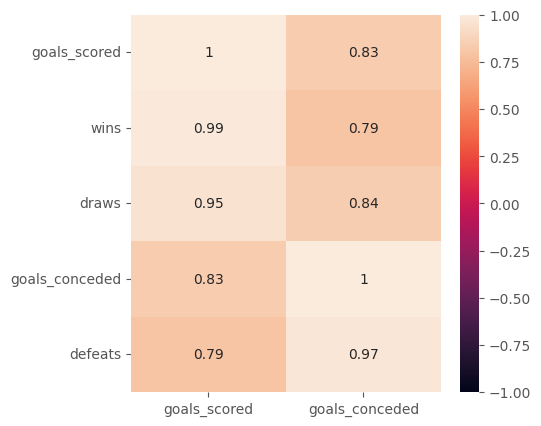

In [67]:
df = pd.read_csv(path.join(PATH_DST, 'teams_statistics.csv')).drop(columns=['Unnamed: 0','games', 'home_games', 'away_games',
    'neutral_games','home_wins', 'away_wins', 'neutral_wins','home_defeats', 'away_defeats', 'neutral_defeats','home_draws', 'away_draws', 'neutral_draws','home_goals_scored', 'away_goals_scored',
    'neutral_goals_scored','home_goals_conceded',
    'away_goals_conceded', 'neutral_goals_conceded'])

# sns.heatmap(df.corr(method='spearman'), annot=True)

plt.figure(figsize=(5, 5))
sns.heatmap(df.corr(method='spearman')[['goals_scored','goals_conceded']].sort_values(by=['goals_scored','goals_conceded'], ascending=False), vmin=-1, vmax=1, annot=True)

plt.show()

correlazione tra partite giocate in casa/ fuori casa e partite neutrali/away/home

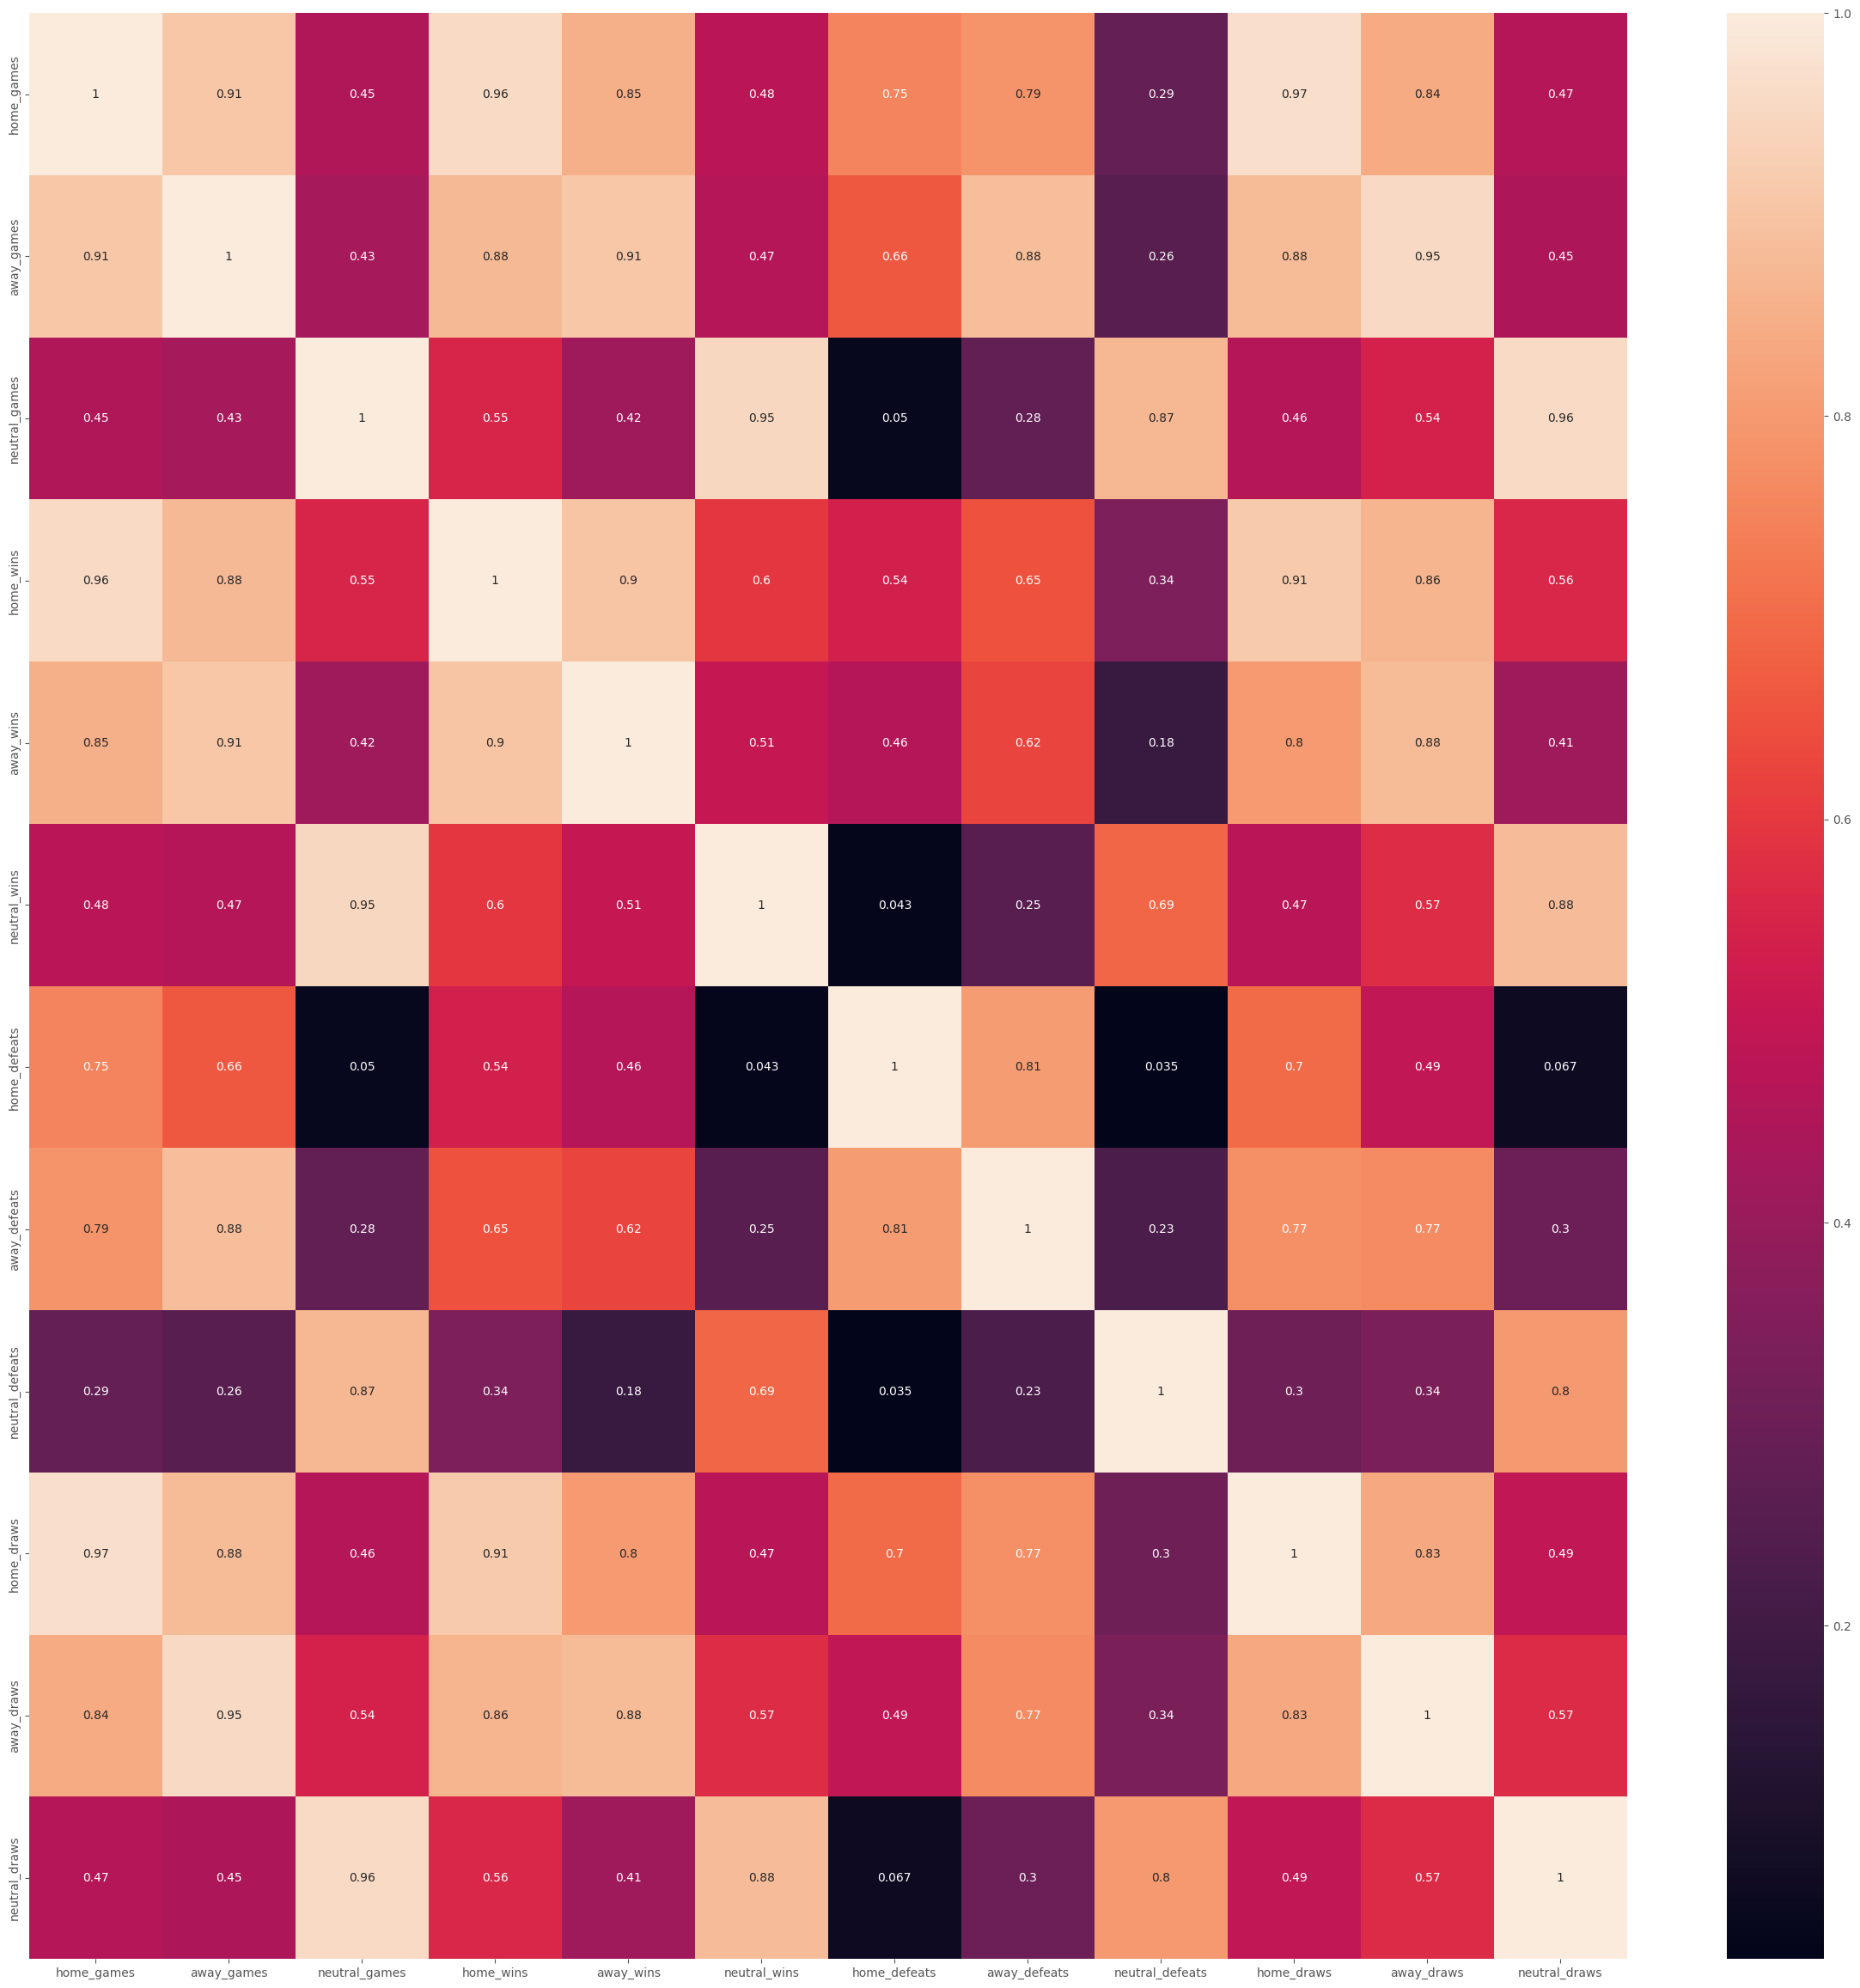

In [68]:
# df = pd.read_csv(path.join(PATH_DST, 'teams_statistics.csv')).drop(columns=['Unnamed: 0'])

# correlated = df.corr(method='spearman').unstack().sort_values(ascending=False).drop_duplicates()
# correlated[1:15]

# strong_corr = correlated[(correlated >= .7) & (correlated <= 1)]
# moderate_corr = correlated[(correlated >= .3) & (correlated <= .7)]
# weak_corr = correlated[(correlated >= .0) & (correlated <= .3)]

# print(strong_corr.__len__())
# print(moderate_corr.__len__())
# print(weak_corr.__len__())
# print(strong_corr)
# strong_corr.to_csv("output.csv")

df = pd.read_csv(path.join(PATH_DST, 'teams_statistics.csv')).drop(columns=['Unnamed: 0', 'confederation', 'games','wins','defeats','draws','goals_scored', 'home_goals_scored', 'away_goals_scored',
    'neutral_goals_scored', 'goals_conceded', 'home_goals_conceded',
    'away_goals_conceded', 'neutral_goals_conceded'])

# df.columns.values

sns.heatmap(df.corr(),annot=True)
plt.show()

## Parte 3 - Proposta modello ed implementazione

In [2]:
df = pd.read_csv(path.join(PATH_DST, 'v3/dataset.csv')).drop(columns=['Unnamed: 0'])

### 3A - Visualizzazioni

Somma cumulativa dei risultati una specifica squadra

100 wins
84 draws
78 defeats


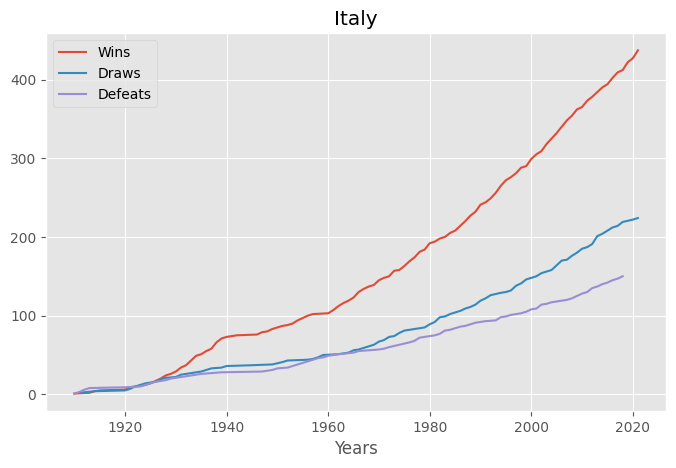

In [3]:
plt.rcParams.update({'figure.figsize':(8,5), 'figure.dpi':100})
show_cdf(df, 'Italy')

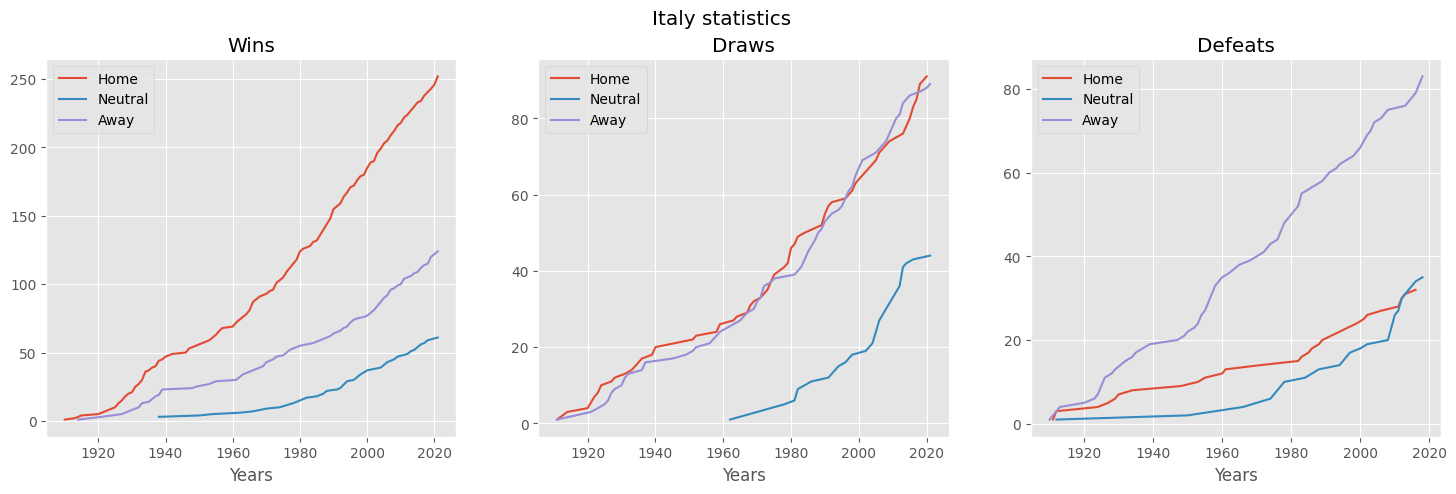

In [4]:
plt.rcParams.update({'figure.figsize':(18,5), 'figure.dpi':100})

show_cdf_splitted(df, 'Italy')

Boxplot goal fatti / concessi rispettivamente nella squadra di casa e non

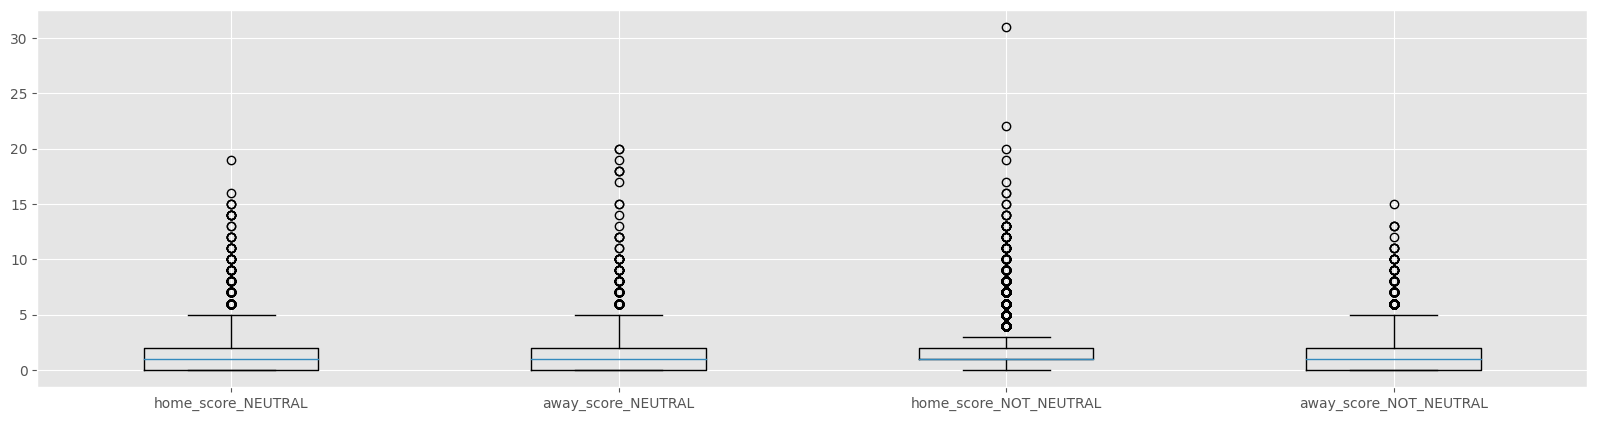

In [5]:
# boxplot con i goal medi delle squadre

neutral_games = df.query("neutral == True")
not_neutral_games = df.query("neutral == False")

plt.figure(figsize=(20,5))
scores = {
    'home_score_NEUTRAL': neutral_games['home_score'], 'away_score_NEUTRAL': neutral_games['away_score'],
    'home_score_NOT_NEUTRAL': not_neutral_games['home_score'], 'away_score_NOT_NEUTRAL': not_neutral_games['away_score'],
    }
plt.boxplot(scores.values())

ax = plt.gca()
ax.set_xticklabels(scores.keys())

plt.show()

### 3B - Individuo la distribuzione e controllo la correlazione

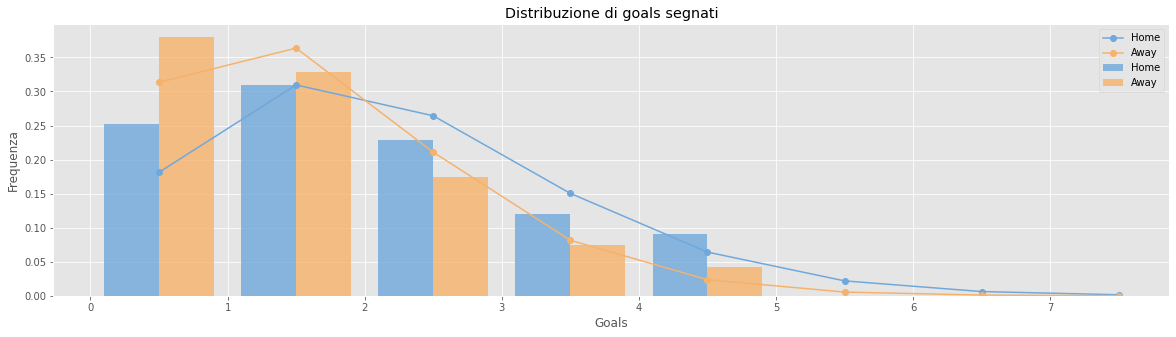

In [7]:
# confronto l'istogramma con la distribuzione di poisson per vedere se sono simili
plt.figure(figsize=(20,5))

plt.hist(df[['home_score', 'away_score']].values, range(6), alpha=0.8, label=['Home', 'Away'], density=True, color=["#6fa8dc", "#f6b26b"])

means = df[['home_score','away_score']].mean()
# predizioni di poisson di ogni goal per la media dei goal
poisson_pred = np.column_stack([[poisson.pmf(k, means[j]) for k in range(8)] for j in range(2)])

plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0],linestyle='-', marker='o',label="Home", color = '#6fa8dc')
plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1],linestyle='-', marker='o',label="Away", color = '#f6b26b')

plt.legend()
plt.title("Distribuzione di goals segnati")
plt.xlabel("Goals")
plt.ylabel("Frequenza")
plt.show()

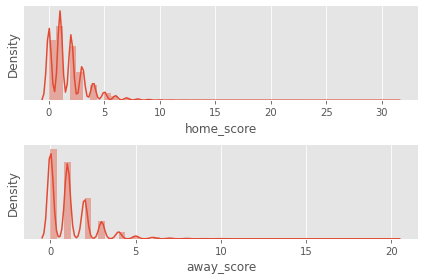

Skewness home_score: 1.991680
Skewness away_score: 2.243736
Kurtosis home_score: 1.991680
Kurtosis away_score: 2.243736


In [8]:
# devo individuare la distribuzione notevole che più approssima il campione preso in esame.

# nota: voglio prevedere il numero di goal fatti dalla squadra home e quella away

# Supponiamo di sapere per certo che i pesi si distribuiscono secondo una distribuzione Gaussiana ed 
# effettuiamo il fit dei parametri. Confrontiamo dunque la Gaussiana trovata con l'istogramma di densità e la
# stima di densità del campione:

fig, axs = plt.subplots(2,1)
sns.despine(left=True)

sns.distplot(df['home_score'], ax=axs[0])
sns.distplot(df['away_score'], ax=axs[1])

plt.setp(axs, yticks=[])
plt.tight_layout()
plt.show()

print("Skewness home_score: %f" % df['home_score'].skew())
print("Skewness away_score: %f" % df['away_score'].skew())
print("Kurtosis home_score: %f" % df['home_score'].skew())
print("Kurtosis away_score: %f" % df['away_score'].skew())

# da notare l'asimmetria a dx e scriverlo.. e curtosi verso un certo punto.

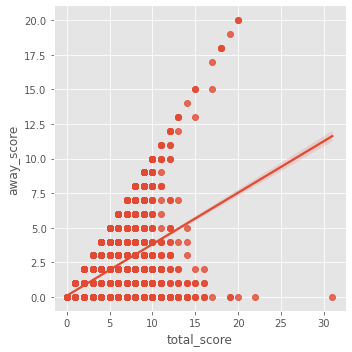

In [9]:
df['total_score'] = df['home_score'] + df['away_score']
sns.lmplot('total_score','away_score',data=df)
plt.show()

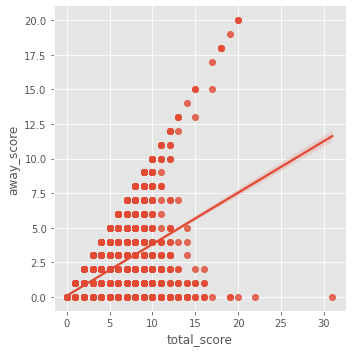

In [10]:
sns.lmplot('total_score','away_score',data=df)
plt.show()

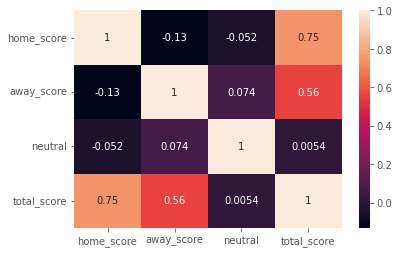

In [11]:
sns.heatmap(df.drop(columns=['year']).corr(),annot=True)
plt.show()

### 3C - Rimozione outliers

In [6]:
df.describe()

,home_score,away_score,year
count,38379.000000,38379.000000,38379.000000
mean,1.707262,1.159827,1991.267021
std,1.690776,1.347911,24.611988
min,0.000000,0.000000,1872.000000
25%,1.000000,0.000000,1979.000000
50%,1.000000,1.000000,1998.000000
75%,2.000000,2.000000,2010.000000
max,31.000000,20.000000,2021.000000


In [7]:
print(f"rows before removing: {df.shape[0]}")
df = remove_outliers(df, 'home_score')
df = remove_outliers(df, 'away_score')
print(f"rows after removing: {df.shape[0]}")

df.to_csv(path.join(PATH_DST, 'v3/dataset_outliers_removed.csv'))

rows before removing: 38379
rows after removing: 32850


In [21]:
df.describe()

,home_score,away_score,year
count,32850.000000,32850.000000,32850.000000
mean,1.248493,1.071750,1992.593333
std,0.999293,1.076086,23.279343
min,0.000000,0.000000,1872.000000
25%,0.000000,0.000000,1981.000000
50%,1.000000,1.000000,1999.000000
75%,2.000000,2.000000,2010.000000
max,3.000000,4.000000,2021.000000


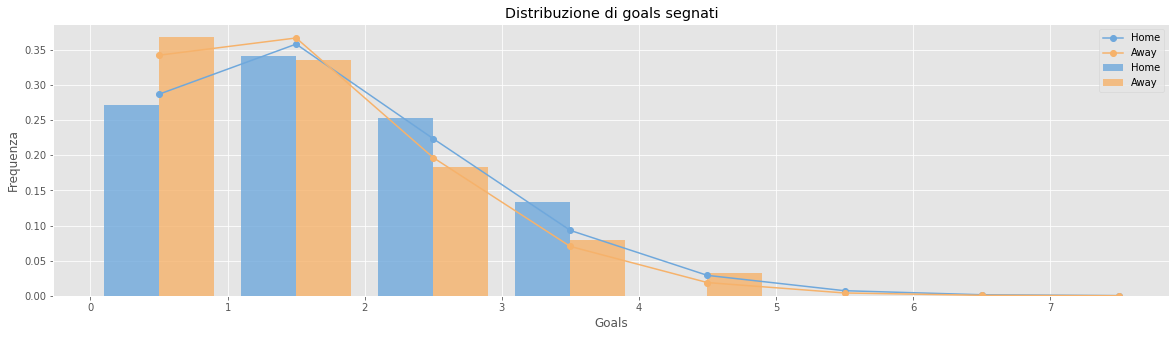

In [30]:
# confronto l'istogramma con la distribuzione di poisson per vedere se sono simili
plt.figure(figsize=(20,5))

plt.hist(df[['home_score', 'away_score']].values, range(8), alpha=0.8, label=['Home', 'Away'], density=True, color=["#6fa8dc", "#f6b26b"])

means = df[['home_score','away_score']].mean()
# predizioni di poisson di ogni goal per la media dei goal
poisson_pred = np.column_stack([[poisson.pmf(k, means[j]) for k in range(8)] for j in range(2)])

plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0],linestyle='-', marker='o',label="Home", color = '#6fa8dc')
plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1],linestyle='-', marker='o',label="Away", color = '#f6b26b')

plt.legend()
plt.title("Distribuzione di goals segnati")
plt.xlabel("Goals")
plt.ylabel("Frequenza")
plt.show()

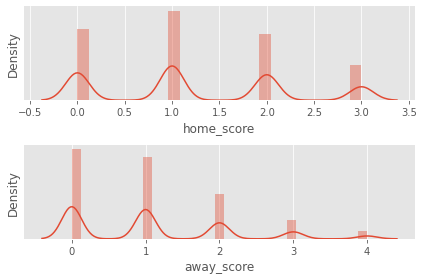

Skewness home_score: 0.291400
Skewness away_score: 0.867715
Kurtosis home_score: 0.291400
Kurtosis away_score: 0.867715


In [22]:
fig, axs = plt.subplots(2,1)
sns.despine(left=True)

sns.distplot(df['home_score'], ax=axs[0])
sns.distplot(df['away_score'], ax=axs[1])

plt.setp(axs, yticks=[])
plt.tight_layout()
plt.show()

print("Skewness home_score: %f" % df['home_score'].skew())
print("Skewness away_score: %f" % df['away_score'].skew())
print("Kurtosis home_score: %f" % df['home_score'].skew())
print("Kurtosis away_score: %f" % df['away_score'].skew())

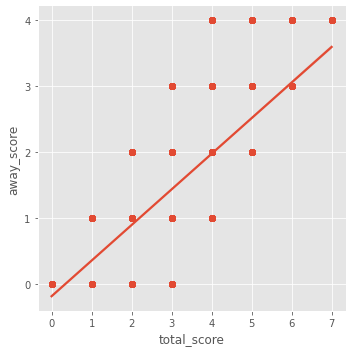

In [24]:
df['total_score'] = df['home_score'] + df['away_score']
sns.lmplot('total_score','away_score',data=df)
plt.show()

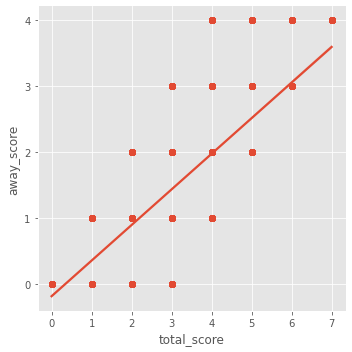

In [25]:
sns.lmplot('total_score','away_score',data=df)
plt.show()

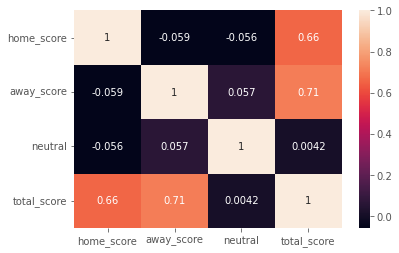

In [26]:
sns.heatmap(df.drop(columns=['year']).corr(),annot=True)
plt.show()

## 3D - Implementazione del modello

In [3]:
df = pd.read_csv(path.join(PATH_DST, 'v3/dataset.csv')).drop(columns=['Unnamed: 0'])
df_no_outliers = pd.read_csv(path.join(PATH_DST, 'v3/dataset_outliers_removed.csv')).drop(columns=['Unnamed: 0'])

df = format_columns(df)
df_no_outliers = format_columns(df_no_outliers)

df.to_csv(path.join(PATH_DST, 'v3/formatted/dataset.csv'))
df_no_outliers.to_csv(path.join(PATH_DST, 'v3/formatted/dataset_outliers_removed.csv'))

Label encoding -- deprecato ? 

In [ ]:
# df = label_encoding(df)
# df_no_outliers = label_encoding(df_no_outliers)

# df.to_csv(path.join(PATH_DST, 'v3/label_encoding/dataset.csv'))
# df_no_outliers.to_csv(path.join(PATH_DST, 'v3/label_encoding/dataset_outliers_removed.csv'))

In [5]:
df.corr()

,home_score,away_score,neutral,outcome,year
home_score,1.000000,-0.132172,-0.052299,-0.107808,-0.131052
away_score,-0.132172,1.000000,0.073685,0.461506,-0.138254
neutral,-0.052299,0.073685,1.000000,0.042491,0.102566
outcome,-0.107808,0.461506,0.042491,1.000000,-0.036751
year,-0.131052,-0.138254,0.102566,-0.036751,1.000000


In [6]:
df_no_outliers.corr()

,home_score,away_score,neutral,outcome,year
home_score,1.000000,-0.058650,-0.055721,-0.151539,-0.085580
away_score,-0.058650,1.000000,0.057241,0.474632,-0.117533
neutral,-0.055721,0.057241,1.000000,0.037535,0.100140
outcome,-0.151539,0.474632,0.037535,1.000000,-0.027512
year,-0.085580,-0.117533,0.100140,-0.027512,1.000000


In [14]:
country_corr = df.country.str.get_dummies(sep=' ').corrwith(df.home_score/df.home_score.max())
print("Media correlazione tra home_score e country %f" % country_corr.mean())
country_corr = df.country.str.get_dummies(sep=' ').corrwith(df.away_score/df.away_score.max())
print("Media correlazione tra away_score e country %f" % country_corr.mean())


Media correlazione tra home_score e country -0.001842
Media correlazione tra away_score e country 0.002000


Basso di media quindi non lo considero

In [45]:
df = pd.read_csv(path.join(PATH_DST, 'v3/formatted/dataset.csv')).drop(columns=['Unnamed: 0'])
df_no_outliers = pd.read_csv(path.join(PATH_DST, 'v3/formatted/dataset_outliers_removed.csv')).drop(columns=['Unnamed: 0'])

datamodel = pd.concat([df[['home_team','away_team','home_score']].rename(columns={'home_team':'team1', 'away_team':'team2','home_score':'goals'}), df[['away_team','home_team','away_score']].rename(columns={'away_team':'team1', 'home_team':'team2','away_score':'goals'})])
datamodel_no_outliers = pd.concat([df_no_outliers[['home_team','away_team','home_score']].rename(columns={'home_team':'team1', 'away_team':'team2','home_score':'goals'}), df_no_outliers[['away_team','home_team','away_score']].rename(columns={'away_team':'team1', 'home_team':'team2','away_score':'goals'})])

print("Datamodel len: %d, Datamodel no outliers len: %d" % ( len(datamodel), len(datamodel_no_outliers)) )

datamodel.head()

Datamodel len: 76758, Datamodel no outliers len: 65700


,team1,team2,goals
0,Scotland,England,0.0
1,England,Scotland,4.0
2,Scotland,England,2.0
3,England,Scotland,2.0
4,Scotland,England,3.0


Versione con outliers

In [3]:
poisson_model = smf.glm(formula="goals ~ team1 + team2", data=datamodel, family=sm.families.Poisson()).fit()
poisson_model.summary()
joblib.dump(poisson_model, 'models/poisson.sav')

['models/poisson.sav']

Versione senza outliers

In [ ]:
poisson_model_no_outliers = smf.glm(formula="goals ~ team1 + team2", data=datamodel_no_outliers, family=sm.families.Poisson()).fit()
print(poisson_model_no_outliers.summary())
# save the model to disk
joblib.dump(poisson_model_no_outliers, 'models/poisson_no_outliers.sav')

## Parte 4 - Test

In [2]:
# load the model from disk
poisson_model = joblib.load('models/poisson.sav')
poisson_model_no_outliers =  joblib.load('models/poisson_no_outliers.sav')

In [21]:
print(get_match_result(poisson_model, 'Germany', 'France'))
print(get_match_result(poisson_model, 'Argentina', 'Germany'))
print(get_match_result(poisson_model, 'England', 'Russia'))
print(get_match_result(poisson_model, 'Italy', 'France'))

('Germany', 'France', [1, 0])
('Argentina', 'Germany', [1, 0])
('England', 'Russia', [1, 0])
('Italy', 'France', [1, 0])


In [ ]:
print(get_match_result(poisson_model_no_outliers, 'Germany', 'France', max_goals= 3 ))
print(get_match_result(poisson_model_no_outliers, 'Argentina', 'Germany', max_goals= 3 ))
print(get_match_result(poisson_model_no_outliers, 'England', 'Russia', max_goals= 3 ))
print(get_match_result(poisson_model_no_outliers, 'Italy', 'France', max_goals= 3 ))